# Technical Analysis with Pandas ([pandas_ta](https://github.com/twopirllc/pandas-ta))
* Below contains examples of simple charts that can be made from pandas_ta indicators
* Examples below are for **educational purposes only**
* **NOTE:** The **watchlist** module is independent of Pandas TA. To easily use it, copy it from your local pandas_ta installation directory into your project directory.

In [1]:
%matplotlib inline
import datetime as dt
import random as rnd

import numpy as np
import pandas as pd
import mplfinance as mpf

from alphaVantageAPI.alphavantage import AlphaVantage
import pandas_ta as ta

from watchlist import colors # Is this failing? If so, copy it locally. See above.

print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")

%pylab inline


Pandas TA v0.2.64b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta

Populating the interactive namespace from numpy and matplotlib


### List of Indicators (post an [issue](https://github.com/twopirllc/pandas-ta/issues) if the indicator doc needs updating)

In [2]:
e = pd.DataFrame()
e.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.2.64b0
Total Indicators: 196
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl, cdl_pattern, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, decay, decreasing, dema, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, kama, kc, kdj, kst, kurtosis, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, ssf, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, trend_return, trima, trix, true_range, tsi, ttm_trend, ui, uo, variance, vidya, vortex, vp, vwap, vwma, wcp, willr, wma,

### Individual Indicator help

In [3]:
help(ta.ema)

Help on function ema in module pandas_ta.overlap.ema:

ema(close, length=None, offset=None, **kwargs)
    Exponential Moving Average (EMA)
    
    The Exponential Moving Average is more responsive moving average compared to the
    Simple Moving Average (SMA).  The weights are determined by alpha which is
    proportional to it's length.  There are several different methods of calculating
    EMA.  One method uses just the standard definition of EMA and another uses the
    SMA to generate the initial value for the rest of the calculation.
    
    Sources:
        https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages
        https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    
    Calculation:
        Default Inputs:
            length=10, adjust=False, sma=True
        if sma:
            sma_nth = close[0:length].sum() / length
            close[:length - 1] = np.NaN
      

### Load Daily SPY from [AlphaVantage](http://www.alphavantage.com) and clean it

In [4]:
def farm(ticker = "SPY", timeframe="DA", cols=["dividend", "split_coefficient"]):
    AV = AlphaVantage(api_key="YOUR API KEY", premium=False, clean=True, output_size="full")
    df = AV.data(symbol=ticker, function=timeframe)
    df.set_index(pd.DatetimeIndex(df["date"]), inplace=True) if not df.ta.datetime_ordered else None
    df.drop(cols, axis=1, inplace=True, errors="ignore")
    df.name = ticker
    return df

def ctitle(indicator_name, ticker="SPY", length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_enddate} ({length})"

def ta_ylim(series: pd.Series, percent: float = 0.1):
    smin, smax = series.min(), series.max()
    if isinstance(percent, float) and 0 <= float(percent) <= 1:
        y_min = (1 + percent) * smin if smin < 0 else (1 - percent) * smin
        y_max = (1 - percent) * smax if smax < 0 else (1 + percent) * smax
        return (y_min, y_max)
    return (smin, smax)

### Initialization

In [5]:
price_size = (16, 8)
ind_size = (16, 3.25)
ticker = "SPY"
# # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 3
# yearly_divisor = 1
# recent = int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yearly_divisor) if yearly_divisor > 0 else df.shape[0]
# print(recent)
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

### Get Ticker and take a peek

In [6]:
# All the Data
df = farm(ticker)
print(f"{df.name}{df.shape} from {df.index[0]} to {df.index[-1]}\n{df.describe()}")
df.head()

SPY(5394, 6) from 1999-11-01 00:00:00 to 2021-04-09 00:00:00
              open         high          low        close    adj_close  \
count  5394.000000  5394.000000  5394.000000  5394.000000  5394.000000   
mean    168.016118   169.010709   166.920680   168.017344   143.128561   
std      70.960074    71.220714    70.662550    70.973501    78.627859   
min      67.949997    70.000000    67.099998    68.110001    53.293084   
25%     117.114999   117.835000   116.227500   117.000000    86.941066   
50%     139.770602   140.650000   138.635002   139.750000   106.548821   
75%     208.070005   209.147500   207.190000   208.332500   186.820489   
max     408.390000   411.670000   408.260000   411.490000   411.490000   

             volume  
count  5.394000e+03  
mean   1.103395e+08  
std    9.694148e+07  
min    1.708170e+05  
25%    4.824947e+07  
50%    8.153653e+07  
75%    1.469538e+08  
max    8.710263e+08  


,open,high,low,close,adj_close,volume
date,,,,,,
1999-11-01,136.500000,137.000000,135.562500,135.562500,90.911009,4006500.0
1999-11-02,135.968704,137.250000,134.593704,134.593704,90.261314,6516900.0
1999-11-03,136.000000,136.375000,135.125000,135.500000,90.869095,7222300.0
1999-11-04,136.750000,137.359299,135.765594,136.531204,91.560642,7907500.0
1999-11-05,138.625000,139.109299,136.781204,137.875000,92.461819,7431500.0


In [7]:
# Recent Data
recent_startdate = df.tail(recent_bars(df)).index[0]
recent_enddate = df.tail(recent_bars(df)).index[-1]
print(f"{df.name}{df.tail(recent_bars(df)).shape} from {recent_startdate} to {recent_enddate}\n{df.describe()}")
df.tail(recent_bars(df)).head()

SPY(252, 6) from 2020-04-09 00:00:00 to 2021-04-09 00:00:00
              open         high          low        close    adj_close  \
count  5394.000000  5394.000000  5394.000000  5394.000000  5394.000000   
mean    168.016118   169.010709   166.920680   168.017344   143.128561   
std      70.960074    71.220714    70.662550    70.973501    78.627859   
min      67.949997    70.000000    67.099998    68.110001    53.293084   
25%     117.114999   117.835000   116.227500   117.000000    86.941066   
50%     139.770602   140.650000   138.635002   139.750000   106.548821   
75%     208.070005   209.147500   207.190000   208.332500   186.820489   
max     408.390000   411.670000   408.260000   411.490000   411.490000   

             volume  
count  5.394000e+03  
mean   1.103395e+08  
std    9.694148e+07  
min    1.708170e+05  
25%    4.824947e+07  
50%    8.153653e+07  
75%    1.469538e+08  
max    8.710263e+08  


,open,high,low,close,adj_close,volume
date,,,,,,
2020-04-09,277.58,281.20,275.47,278.20,273.782855,189948139.0
2020-04-13,277.14,277.51,271.41,275.66,271.283184,114353986.0
2020-04-14,280.98,284.90,275.51,283.79,279.284099,133510280.0
2020-04-15,277.57,283.94,275.46,277.76,273.349841,121155983.0
2020-04-16,279.15,280.03,275.76,279.10,274.668565,126144324.0


### Aliases

In [8]:
opendf = df["open"]
closedf = df["close"]
volumedf = df["volume"]

## DataFrame **constants**: When you need some simple lines for charting

In [9]:
# help(df.ta.constants) # for more info
chart_lines = np.append(np.arange(-5, 6, 1), np.arange(-100, 110, 10))
df.ta.constants(True, chart_lines) # Adding the constants for the charts
df.ta.constants(False, np.array([-60, -40, 40, 60])) # Removing some constants from the DataFrame
print(f"Columns: {', '.join(list(df.columns))}")

Columns: open, high, low, close, adj_close, volume, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, -100, -90, -80, -70, -50, -30, -20, -10, 10, 20, 30, 50, 70, 80, 90, 100


## Example Charting Class utilizing **mplfinance** panels

In [10]:
class Chart(object):
    def __init__(self, df: pd.DataFrame = None, strategy: ta.Strategy = ta.CommonStrategy, *args, **kwargs):
        self.verbose = kwargs.pop("verbose", False)

        if isinstance(df, pd.DataFrame) and df.ta.datetime_ordered:
            self.df = df
            if self.df.name is not None and self.df.name != "":
                df_name = str(self.df.name)
            else:
                df_name = "DataFrame"
            if self.verbose: print(f"[i] Loaded {df_name}{self.df.shape}")
        else:
            print(f"[X] Oops! Missing 'ohlcv' data or index is not datetime ordered.\n")
            return None

        self._validate_ta_strategy(strategy)
        self._validate_mpf_kwargs(**kwargs)
        self._validate_chart_kwargs(**kwargs)

        # Build TA and Plot
        self.df.ta.strategy(self.strategy, verbose=self.verbose)
        self._plot(**kwargs)

    def _validate_ta_strategy(self, strategy):
        if strategy is not None or isinstance(strategy, ta.Strategy):
            self.strategy = strategy
        elif len(self.strategy_ta) > 0:
            print(f"[+] Strategy: {self.strategy_name}")
        else:
            self.strategy = ta.CommonStrategy        

    def _validate_chart_kwargs(self, **kwargs):
        """Chart Settings"""
        self.config = {}
        self.config["last"] = kwargs.pop("last", recent_bars(self.df))
        self.config["rpad"] = kwargs.pop("rpad", 10)
        self.config["title"] = kwargs.pop("title", "Asset")
        self.config["volume"] = kwargs.pop("volume", True)

    def _validate_mpf_kwargs(self, **kwargs):
        # mpf global chart settings
        default_chart = mpf.available_styles()[-1]
        default_mpf_width = {
            'candle_linewidth': 0.6,
            'candle_width': 0.525,
            'volume_width': 0.525
        }
        mpfchart = {}

        mpf_style = kwargs.pop("style", "")
        if mpf_style == "" or mpf_style.lower() == "random":
            mpf_styles = mpf.available_styles()
            mpfchart["style"] = mpf_styles[rnd.randrange(len(mpf_styles))]
        elif mpf_style.lower() in mpf.available_styles():
            mpfchart["style"] = mpf_style

        mpfchart["figsize"] = kwargs.pop("figsize", (12, 10))
        mpfchart["non_trading"] = kwargs.pop("nontrading", False)
        mpfchart["rc"] = kwargs.pop("rc", {'figure.facecolor': '#EDEDED'})
        mpfchart["plot_ratios"] = kwargs.pop("plot_ratios", (12, 1.7))
        mpfchart["scale_padding"] = kwargs.pop("scale_padding", {'left': 1, 'top': 4, 'right': 1, 'bottom': 1})
        mpfchart["tight_layout"] = kwargs.pop("tight_layout", True)
        mpfchart["type"] = kwargs.pop("type", "candle")
        mpfchart["width_config"] = kwargs.pop("width_config", default_mpf_width)
        mpfchart["xrotation"] = kwargs.pop("xrotation", 15)
        
        self.mpfchart = mpfchart

    def _attribution(self):
        print(f"\nPandas v: {pd.__version__} [pip install pandas] https://github.com/pandas-dev/pandas")
        print(f"Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI")
        print(f"Technical Analysis with Pandas TA v: {ta.version} [pip install pandas_ta] https://github.com/twopirllc/pandas-ta")
        print(f"Charts by Matplotlib Finance v: {mpf.__version__} [pip install mplfinance] https://github.com/matplotlib/mplfinance\n")

    def _right_pad_df(self, rpad: int, delta_unit: str = "D", range_freq: str = "B"):
        if rpad > 0:
            dfpad = self.df[-rpad:].copy()
            dfpad.iloc[:,:] = np.NaN

            df_frequency = self.df.index.value_counts().mode()[0] # Most common frequency
            freq_delta = pd.Timedelta(df_frequency, unit=delta_unit)
            new_dr = pd.date_range(start=self.df.index[-1] + freq_delta, periods=rpad, freq=range_freq)
            dfpad.index = new_dr # Update the padded index with new dates
            self.df = self.df.append(dfpad)
        
            
    def _plot(self, **kwargs):
        if not isinstance(self.mpfchart["plot_ratios"], tuple):
            print(f"[X] plot_ratios must be a tuple")
            return

        # Override Chart Title Option
        chart_title = self.config["title"]
        if "title" in kwargs and isinstance(kwargs["title"], str):
            chart_title = kwargs.pop("title")

        # Override Right Bar Padding Option
        rpad = self.config["rpad"]
        if "rpad" in kwargs and kwargs["rpad"] > 0:
            rpad = int(kwargs["rpad"])

        def cpanel():
            return len(self.mpfchart['plot_ratios'])

        # Last Second Default TA Indicators
        linreg = kwargs.pop("linreg", False)
        linreg_name = self.df.ta.linreg(append=True).name if linreg else ""

        midpoint = kwargs.pop("midpoint", False)
        midpoint_name = self.df.ta.midpoint(append=True).name if midpoint else ""

        ohlc4 = kwargs.pop("ohlc4", False)
        ohlc4_name = self.df.ta.ohlc4(append=True).name if ohlc4 else ""

        clr = kwargs.pop("clr", False)
        clr_name = self.df.ta.log_return(cumulative=True, append=True).name if clr else ""

        rsi = kwargs.pop("rsi", False)
        rsi_length = kwargs.pop("rsi_length", None)
        if isinstance(rsi_length, int) and rsi_length > 1:
            rsi_name = self.df.ta.rsi(length=rsi_length, append=True).name
        elif rsi:
            rsi_name = self.df.ta.rsi(append=True).name
        else: rsi_name = ""
            
        zscore = kwargs.pop("zscore", False)
        zscore_length = kwargs.pop("zscore_length", None)
        if isinstance(zscore_length, int) and zscore_length > 1:
            zs_name = self.df.ta.zscore(length=zscore_length, append=True).name
        elif zscore:
            zs_name = self.df.ta.zscore(append=True).name
        else: zs_name = ""

        macd = kwargs.pop("macd", False)
        macd_name = ""
        if macd:
            macds = self.df.ta.macd(append=True)
            macd_name = macds.name

        squeeze = kwargs.pop("squeeze", False)
        lazybear = kwargs.pop("lazybear", False)
        squeeze_name = ""
        if squeeze:
            squeezes = self.df.ta.squeeze(lazybear=lazybear, detailed=True, append=True)
            squeeze_name = squeezes.name

        ama = kwargs.pop("archermas", False)
        ama_name = ""
        if ama:
            amas = self.df.ta.amat(append=True)
            ama_name = amas.name

        aobv = kwargs.pop("archerobv", False)
        aobv_name = ""
        if aobv:
            aobvs = self.df.ta.aobv(append=True)
            aobv_name = aobvs.name

        treturn = kwargs.pop("trendreturn", False)
        if treturn:
            # Long Trend requires Series Comparison (<=. <, = >, >=)
            # or Trade Logic that yields trends in binary.
            default_long = self.df["SMA_10"] > self.df["SMA_20"]
            long_trend = kwargs.pop("long_trend", default_long)
            if not isinstance(long_trend, pd.Series):
                raise(f"[X] Must be a Series that has boolean values or values of 0s and 1s")
            short_trend = ~long_trend # Opposite/Inverse
            self.df["TR"] = ta.trend_return(self.df["close"], long_trend).iloc[:,1]

        # Pad and trim Chart
        self._right_pad_df(rpad)
        mpfdf = self.df.tail(self.config["last"])
        mpfdf_columns = list(self.df.columns)

        # BEGIN: Custom TA Plots and Panels
        # Modify the area below 
        taplots = [] # Holds all the additional plots

        # Panel 0: Price Overlay
        if linreg_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[linreg_name], type=kwargs.pop("linreg_type", "line"), color=kwargs.pop("linreg_color", "black"), linestyle="-.", width=1.2, panel=0)]

        if midpoint_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[midpoint_name], type=kwargs.pop("midpoint_type", "scatter"), color=kwargs.pop("midpoint_color", "fuchsia"), width=0.4, panel=0)]

        if ohlc4_name in mpfdf_columns:
            taplots += [mpf.make_addplot(mpfdf[ohlc4_name], ylabel=ohlc4_name, type=kwargs.pop("ohlc4_type", "scatter"), color=kwargs.pop("ohlc4_color", "blue"), alpha=0.85, width=0.4, panel=0)]

        if self.strategy.name == ta.CommonStrategy.name:
            total_sma = 0 # Check if all the overlap indicators exists before adding plots
            for c in ["SMA_10", "SMA_20", "SMA_50", "SMA_200"]:
                if c in mpfdf_columns: total_sma += 1
                else: print(f"[X] Indicator: {c} missing!")
            if total_sma == 4:
                ta_smas = [
                    mpf.make_addplot(mpfdf["SMA_10"], color="green", width=1.5, panel=0),
                    mpf.make_addplot(mpfdf["SMA_20"], color="orange", width=2, panel=0),
                    mpf.make_addplot(mpfdf["SMA_50"], color="red", width=2, panel=0),
                    mpf.make_addplot(mpfdf["SMA_200"], color="maroon", width=3, panel=0),
                ]
                taplots += ta_smas

        if len(ama_name):
            amat_sr_ = mpfdf[amas.columns[-1]][mpfdf[amas.columns[-1]] > 0]
            amat_sr = amat_sr_.index.to_list()
        else:
            amat_sr = None

        # Panel 1: If volume=True, the add the VOL MA. Since we know there is only one, we immediately pop it.
        if self.config["volume"]:
            volma = [x for x in list(self.df.columns) if x.startswith("VOL_")].pop()
            max_vol = mpfdf["volume"].max()
            ta_volume = [mpf.make_addplot(mpfdf[volma], color="red", width=2, panel=1, ylim=(-.2 * max_vol, 1.5 * max_vol))]
            taplots += ta_volume

        # Panels 2 - 9
        common_plot_ratio = (3,)

        if len(aobv_name):
            _p = kwargs.pop("aobv_percenty", 0.2)
            aobv_ylim = ta_ylim(mpfdf[aobvs.columns[0]], _p)
            taplots += [
                mpf.make_addplot(mpfdf[aobvs.columns[0]], ylabel=aobv_name, color="black", width=1.5, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[2]], color="silver", width=1, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[3]], color="green", width=1, panel=cpanel(), ylim=aobv_ylim),
                mpf.make_addplot(mpfdf[aobvs.columns[4]], color="red", width=1.2, panel=cpanel(), ylim=aobv_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if clr_name in mpfdf_columns:
            _p = kwargs.pop("clr_percenty", 0.1)
            clr_ylim = ta_ylim(mpfdf[clr_name], _p)

            taplots += [mpf.make_addplot(mpfdf[clr_name], ylabel=clr_name, color="black", width=1.5, panel=cpanel(), ylim=clr_ylim)]
            if (1 - _p) * mpfdf[clr_name].min() < 0 and (1 + _p) * mpfdf[clr_name].max() > 0:
                taplots += [mpf.make_addplot(mpfdf["0"], color="gray", width=1.2, panel=cpanel(), ylim=clr_ylim)]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if rsi_name in mpfdf_columns:
            rsi_ylim = (0, 100)
            taplots += [
                mpf.make_addplot(mpfdf[rsi_name], ylabel=rsi_name, color=kwargs.pop("rsi_color", "black"), width=1.5, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["20"], color="green", width=1, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["50"], color="gray", width=0.8, panel=cpanel(), ylim=rsi_ylim),
                mpf.make_addplot(mpfdf["80"], color="red", width=1, panel=cpanel(), ylim=rsi_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel
        
        if macd_name in mpfdf_columns:
            _p = kwargs.pop("macd_percenty", 0.15)
            macd_ylim = ta_ylim(mpfdf[macd_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[macd_name], ylabel=macd_name, color="black", width=1.5, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf[macds.columns[-1]], color="blue", width=1.1, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf[macds.columns[1]], type="bar", alpha=0.8, color="dimgray", width=0.8, panel=cpanel()),#, ylim=macd_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel()),#, ylim=macd_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel            

        if zs_name in mpfdf_columns:
            _p = kwargs.pop("zascore_percenty", 0.2)
            zs_ylim = ta_ylim(mpfdf[zs_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[zs_name], ylabel=zs_name, color="black", width=1.5, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-3"], color="red", width=1.2, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-2"], color="orange", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["-1"], color="silver", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["1"], color="silver", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["2"], color="orange", width=1, panel=cpanel(), ylim=zs_ylim),
                mpf.make_addplot(mpfdf["3"], color="red", width=1.2, panel=cpanel(), ylim=zs_ylim)
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if squeeze_name in mpfdf_columns:
            _p = kwargs.pop("squeeze_percenty", 0.6)
            sqz_ylim = ta_ylim(mpfdf[squeeze_name], _p)
            taplots += [
                mpf.make_addplot(mpfdf[squeezes.columns[-4]], type="bar", color="lime", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-3]], type="bar", color="green", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-2]], type="bar", color="maroon", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[-1]], type="bar", color="red", alpha=0.65, width=0.8, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1.2, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[4]], ylabel=squeeze_name, color="green", width=2, panel=cpanel(), ylim=sqz_ylim),
                mpf.make_addplot(mpfdf[squeezes.columns[5]], color="red", width=1.8, panel=cpanel(), ylim=sqz_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        if treturn:
            _p = kwargs.pop("treturn_percenty", 0.33)
            treturn_ylim = ta_ylim(mpfdf["TR"], _p)
            taplots += [
                mpf.make_addplot(mpfdf["TR"], ylabel="Trend Return", type="bar", color="green", alpha=0.45, width=0.8, panel=cpanel(), ylim=treturn_ylim),
                mpf.make_addplot(mpfdf["TR"], color="black", width=1.3, panel=cpanel(), ylim=treturn_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1, panel=cpanel(), ylim=treturn_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

            _p = kwargs.pop("cstreturn_percenty", 0.33)
#             trcs = mpfdf["TR"].cumsum()
            trcs = mpfdf["close"] / mpfdf["close"].iloc[0]
            treturncs_ylim = ta_ylim(trcs, _p)
            taplots += [
                mpf.make_addplot(trcs, ylabel="Trend B&H", type="bar", color="green", alpha=0.45, width=0.8, panel=cpanel(), ylim=treturncs_ylim),
                mpf.make_addplot(mpfdf["0"], color="black", width=1, panel=cpanel(), ylim=treturncs_ylim),
            ]
            self.mpfchart["plot_ratios"] += common_plot_ratio # Required to add a new Panel

        # END: Custom TA Plots and Panels

        if self.verbose:
            additional_ta = []
            chart_title  = f"{chart_title} [{self.strategy.name}] (last {self.config['last']} bars)"
            chart_title += f"\nSince {mpfdf.index[0]} till {mpfdf.index[-1]}"
            if len(linreg_name) > 0: additional_ta.append(linreg_name)
            if len(midpoint_name) > 0: additional_ta.append(midpoint_name)
            if len(ohlc4_name) > 0: additional_ta.append(ohlc4_name)
            if len(additional_ta) > 0:
                chart_title += f"\nIncluding: {', '.join(additional_ta)}"

        if amat_sr:
            vlines_ = dict(vlines=amat_sr, alpha=0.1, colors="red")
        else:
            # Hidden because vlines needs valid arguments even if None 
            vlines_ = dict(vlines=mpfdf.index[0], alpha=0, colors="white")

        # Create Final Plot
        mpf.plot(mpfdf,
            title=chart_title,
            type=self.mpfchart["type"],
            style=self.mpfchart["style"],
            datetime_format="%-m/%-d/%Y",
            volume=self.config["volume"],
            figsize=self.mpfchart["figsize"],
            tight_layout=self.mpfchart["tight_layout"],
            scale_padding=self.mpfchart["scale_padding"],
            panel_ratios=self.mpfchart["plot_ratios"], # This key needs to be update above if adding more panels
            xrotation=self.mpfchart["xrotation"],
            update_width_config=self.mpfchart["width_config"],
            show_nontrading=self.mpfchart["non_trading"],
            vlines=vlines_,
            addplot=taplots
        )
        
        self._attribution()

### Charting Example
#### Play with the parameters to see different charts and results
* This is an example chart so it's not perfect. Enough to get started with common and uncommon plots.
* There is a maximum of 10 Panels. In this example, panels 0 and 1 are reserved for Price and Volume respectively.
    * 

[i] Loaded SPY(5394, 33)
[+] Strategy: Common Price and Volume SMAs
[i] Indicator arguments: {'append': True}
[i] Multiprocessing 5 indicators with 7 chunks and 8/8 cpus.
[i] Total indicators: 5
[i] Columns added: 5
[i] Last Run: Saturday April 10, 2021, NYSE: 12:37:31, Local: 16:37:31 PDT, Day 100/365 (27.0%)


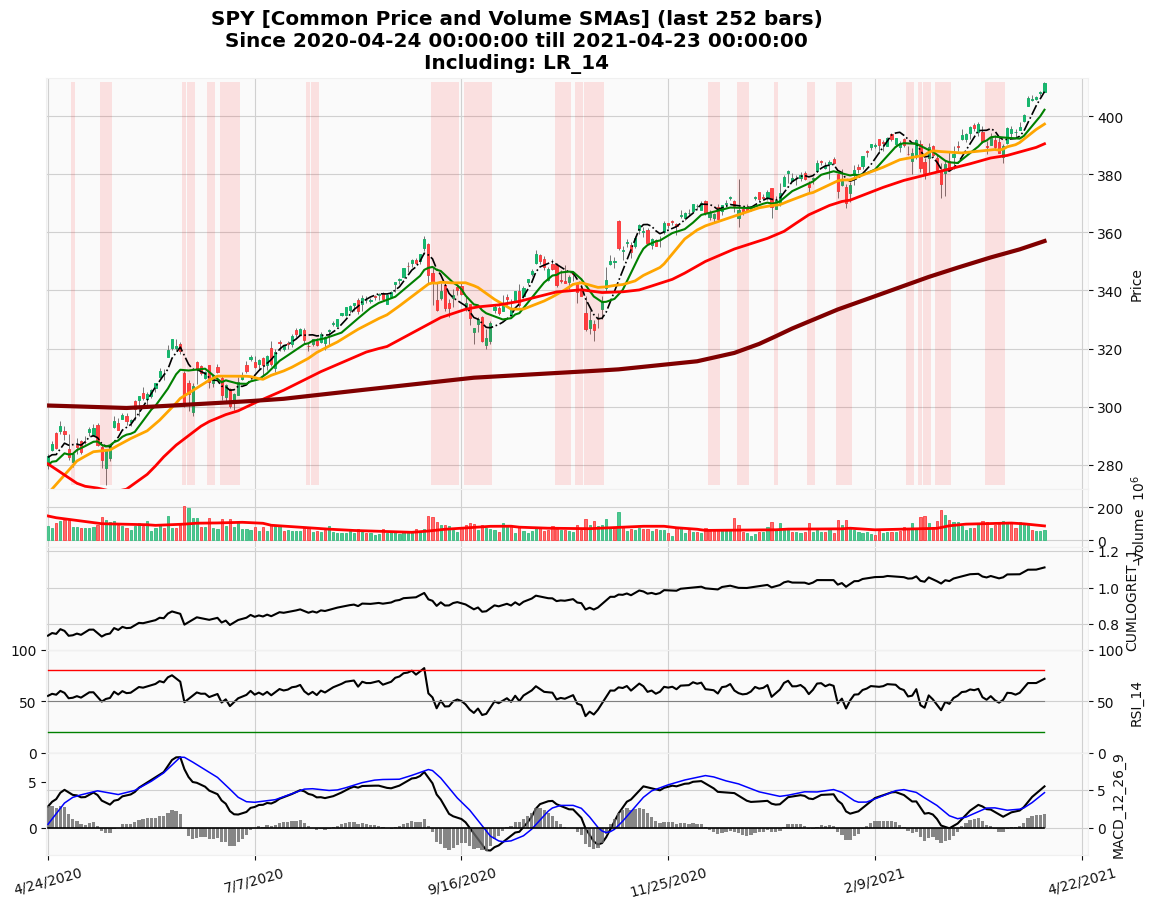


Pandas v: 1.2.2 [pip install pandas] https://github.com/pandas-dev/pandas
Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI
Technical Analysis with Pandas TA v: 0.2.64b0 [pip install pandas_ta] https://github.com/twopirllc/pandas-ta
Charts by Matplotlib Finance v: 0.12.7a5 [pip install mplfinance] https://github.com/matplotlib/mplfinance



In [11]:
# Used for example Trend Return Long Trend Below
macd_ = ta.macd(closedf)
macdh = macd_[macd_.columns[1]]

Chart(df,
    # style: which mplfinance chart style to use. Added "random" as an option.
    # rpad: how many bars to leave empty on the right of the chart
    style="yahoo", title=ticker, last=recent_bars(df), rpad=10,
    
    # Overlap Indicators
    linreg=True, midpoint=False, ohlc4=False, archermas=True,
    
    # Example Indicators with default parameters
    volume=True, rsi=True, clr=True, macd=True, zscore=False, squeeze=False, lazybear=False,

    # Archer OBV and OBV MAs (https://www.tradingview.com/script/Co1ksara-Trade-Archer-On-balance-Volume-Moving-Averages-v1/)
    archerobv=False,

    # Create trends and see their returns
    trendreturn=False,
    # Example Trends or create your own. Trend must yield Booleans
    long_trend=ta.sma(closedf,10) > ta.sma(closedf,20), # trend: sma(close,10) > sma(close,20) [Default Example]
#     long_trend=closedf > ta.ema(closedf,5), # trend: close > ema(close,5)
#     long_trend=ta.sma(closedf,10) > ta.ema(closedf,50), # trend: sma(close,10) > ema(close,50)
#     long_trend=macdh > 0, # trend: macd hist > 0
#     long_trend=ta.increasing(ta.sma(ta.rsi(closedf), 10), 5, asint=False), # trend: rising sma(rsi, 10) for the previous 5 periods
    show_nontrading=False, # Intraday use if needed
    verbose=True, # More detail
)

## Indicator Examples
* Examples of simple and complex indicators.  Most indicators return a Series, while a few return DataFrames.
* All indicators can be called one of three ways. Either way, they return the result.

### Three ways to use pandas_ta
1. Stand Alone like TA-Lib  ta.**indicator**(*kwargs*).
2. As a DataFrame Extension like df.ta.**indicator**(*kwargs*).  Where df is a DataFrame with columns named "open", "high", "low", "close, "volume" for simplicity.
3. Similar to #2, but by calling: df.ta(kind="**indicator**", *kwargs*).

### Cumulative Log Return

<AxesSubplot:title={'center':'SPY: CUMLOGRET_1 from 2020-04-09 00:00:00 to 2021-04-09 00:00:00 (252)'}, xlabel='date'>

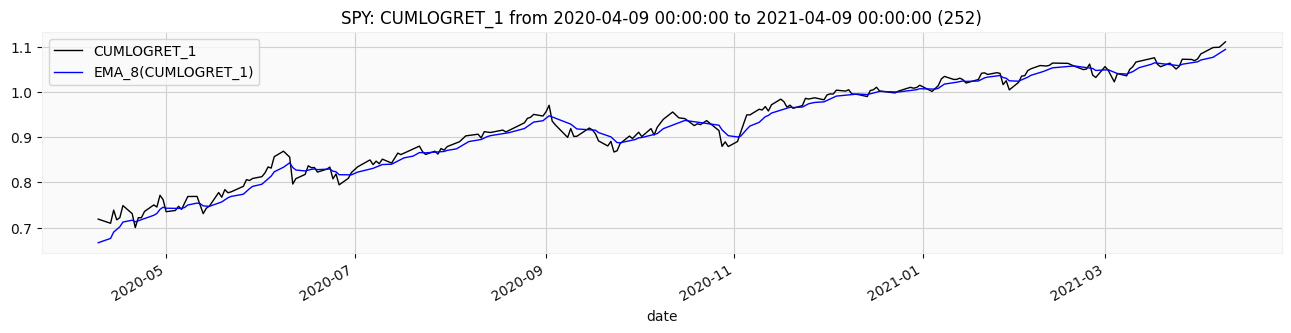

In [12]:
clr_ma_length = 8
clrdf = df.ta.log_return(cumulative=True, append=True)
clrmadf = ta.ema(clrdf, length=clr_ma_length)
clrxdf = pd.DataFrame({f"{clrdf.name}": clrdf, f"{clrmadf.name}({clrdf.name})": clrmadf})
clrxdf.tail(recent_bars(df)).plot(figsize=ind_size, color=colors("BkBl"), linewidth=1, title=ctitle(clrdf.name, ticker=ticker, length=recent_bars(df)), grid=True)

### MACD

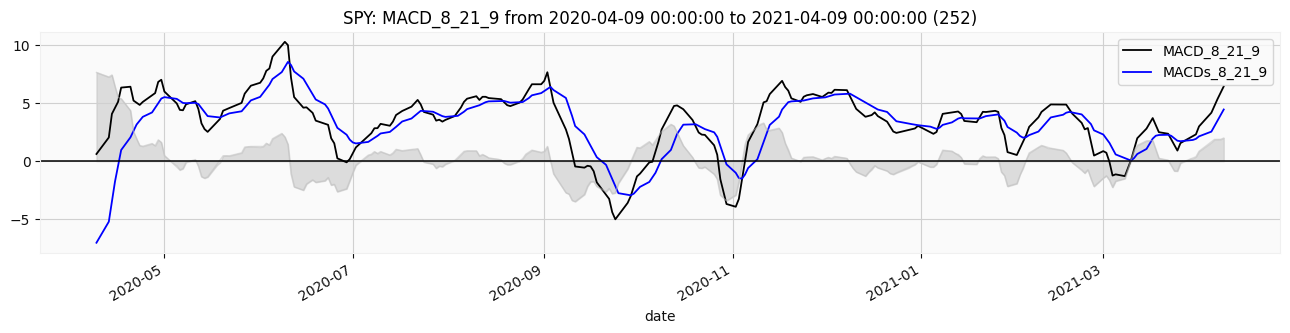

In [13]:
macddf = df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
macddf[[macddf.columns[0], macddf.columns[2]]].tail(recent_bars(df)).plot(figsize=(16, 2), color=colors("BkBl"), linewidth=1.3)
macddf[macddf.columns[1]].tail(recent_bars(df)).plot.area(figsize=ind_size, stacked=False, color=["silver"], linewidth=1, title=ctitle(macddf.name, ticker=ticker, length=recent_bars(df)), grid=True).axhline(y=0, color="black", lw=1.1)

### ZScore

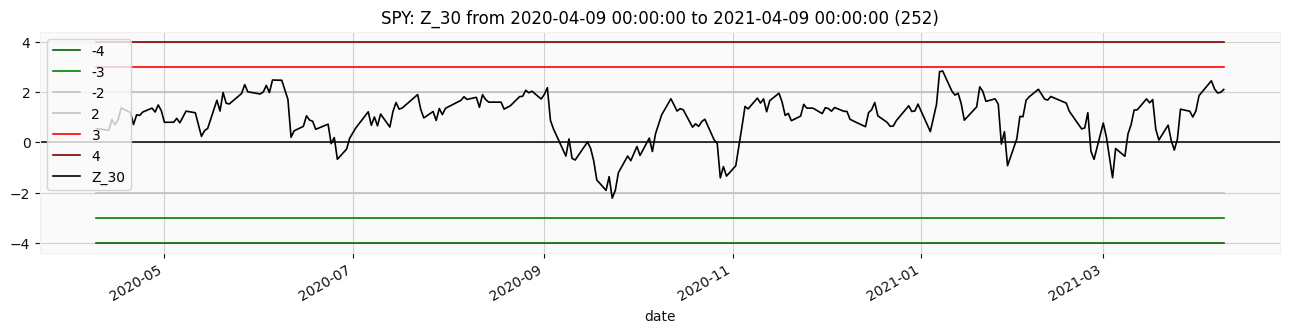

In [14]:
zscoredf = df.ta.zscore(length=30, append=True)
zcolors = ["darkgreen", "green", "silver", "silver", "red", "maroon", "black"]
zcols = df[["-4", "-3", "-2", "2", "3", "4", zscoredf.name]].tail(recent_bars(df))
zcols.plot(figsize=ind_size, color=zcolors, linewidth=1.2, title=ctitle(zscoredf.name, ticker=ticker, length=recent_bars(df)), grid=True).axhline(y=0, color="black", lw=1.1)

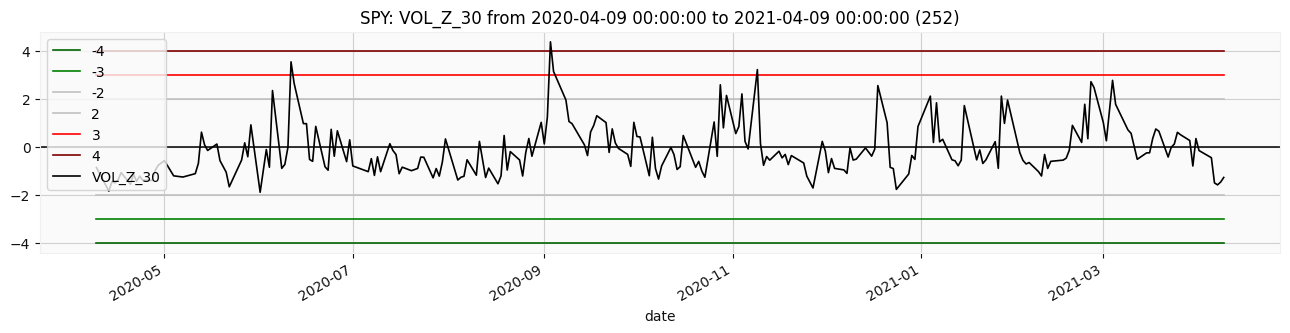

In [15]:
# Now Volume Z Score
zvscoredf = df.ta.zscore(close="volume", length=30, prefix="VOL", append=True)
zcolors = ["darkgreen", "green", "silver", "silver", "red", "maroon", "black"]
zvcols = df[["-4", "-3", "-2", "2", "3", "4", zvscoredf.name]].tail(recent_bars(df))
zvcols.plot(figsize=ind_size, color=zcolors, linewidth=1.2, title=ctitle(zvscoredf.name, ticker=ticker, length=recent_bars(df)), grid=True).axhline(y=0, color="black", lw=1.1)

# New Features

## Squeeze Indicator (John Carter and Lazybear Versions)
Squeeze Indicator (__squeeze__)

In [16]:
# help(ta.squeeze)

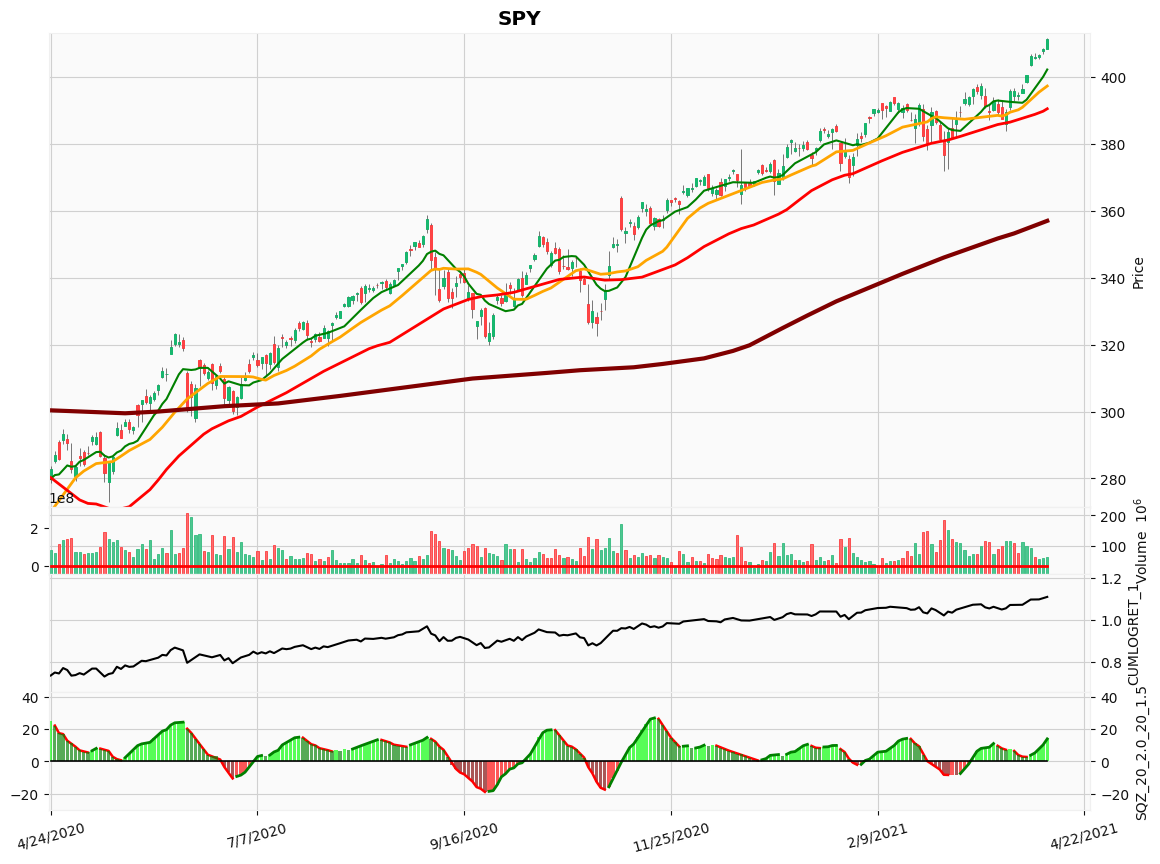


Pandas v: 1.2.2 [pip install pandas] https://github.com/pandas-dev/pandas
Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI
Technical Analysis with Pandas TA v: 0.2.64b0 [pip install pandas_ta] https://github.com/twopirllc/pandas-ta
Charts by Matplotlib Finance v: 0.12.7a5 [pip install mplfinance] https://github.com/matplotlib/mplfinance



In [17]:
Chart(df, style="yahoo", title=ticker, verbose=False,
    last=recent_bars(df), rpad=10, clr=True, squeeze=True,
    show_nontrading=False, # Intraday use if needed
)

### Lazybear's TradingView Squeeze

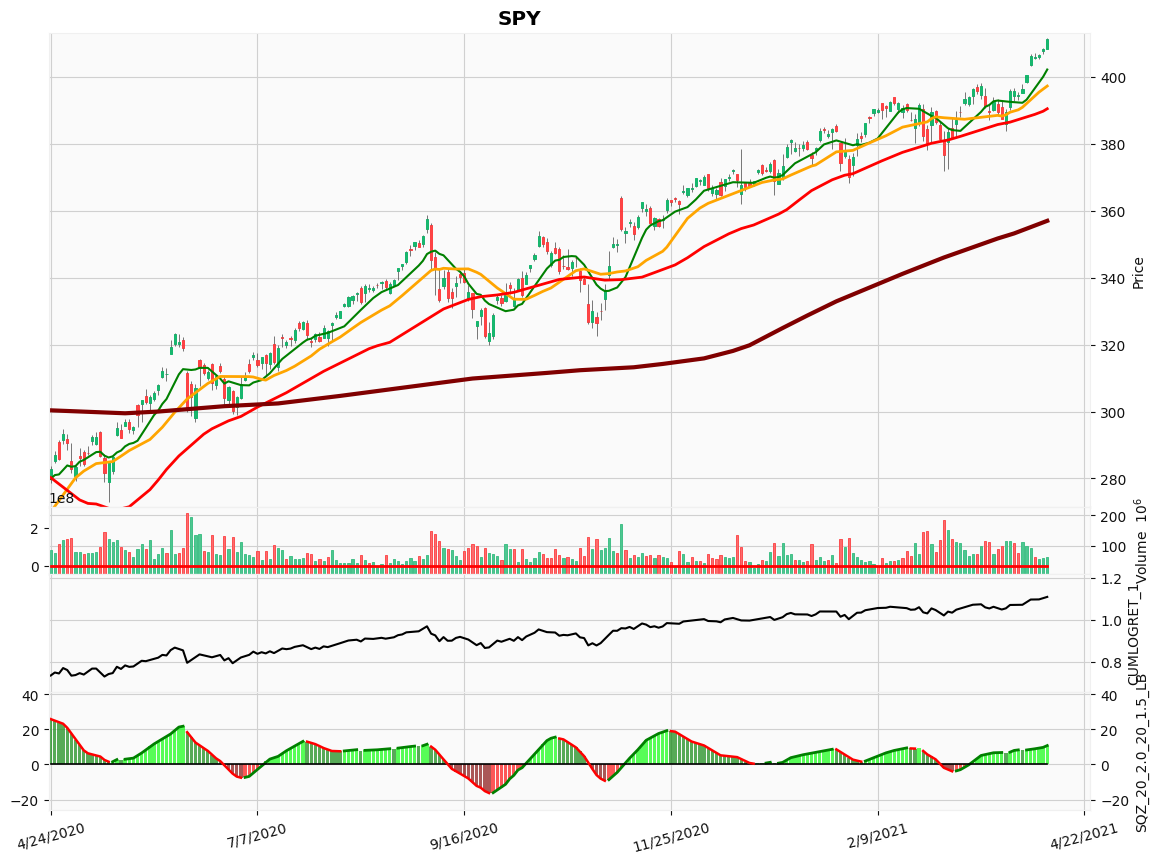


Pandas v: 1.2.2 [pip install pandas] https://github.com/pandas-dev/pandas
Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI
Technical Analysis with Pandas TA v: 0.2.64b0 [pip install pandas_ta] https://github.com/twopirllc/pandas-ta
Charts by Matplotlib Finance v: 0.12.7a5 [pip install mplfinance] https://github.com/matplotlib/mplfinance



In [18]:
Chart(df, style="yahoo", title=ticker, verbose=False,
    last=recent_bars(df), rpad=10, clr=True, squeeze=True, lazybear=True,
    show_nontrading=False, # Intraday use if needed
)

### Archer Moving Averages Trends
Archer Moving Average Trends (__amat__) returns the long and short run trends of fast and slow moving averages.
* The _pink_ background, on the Price chart, is when Archer MAs are bearish. Conversely, a _white_ background is bullish

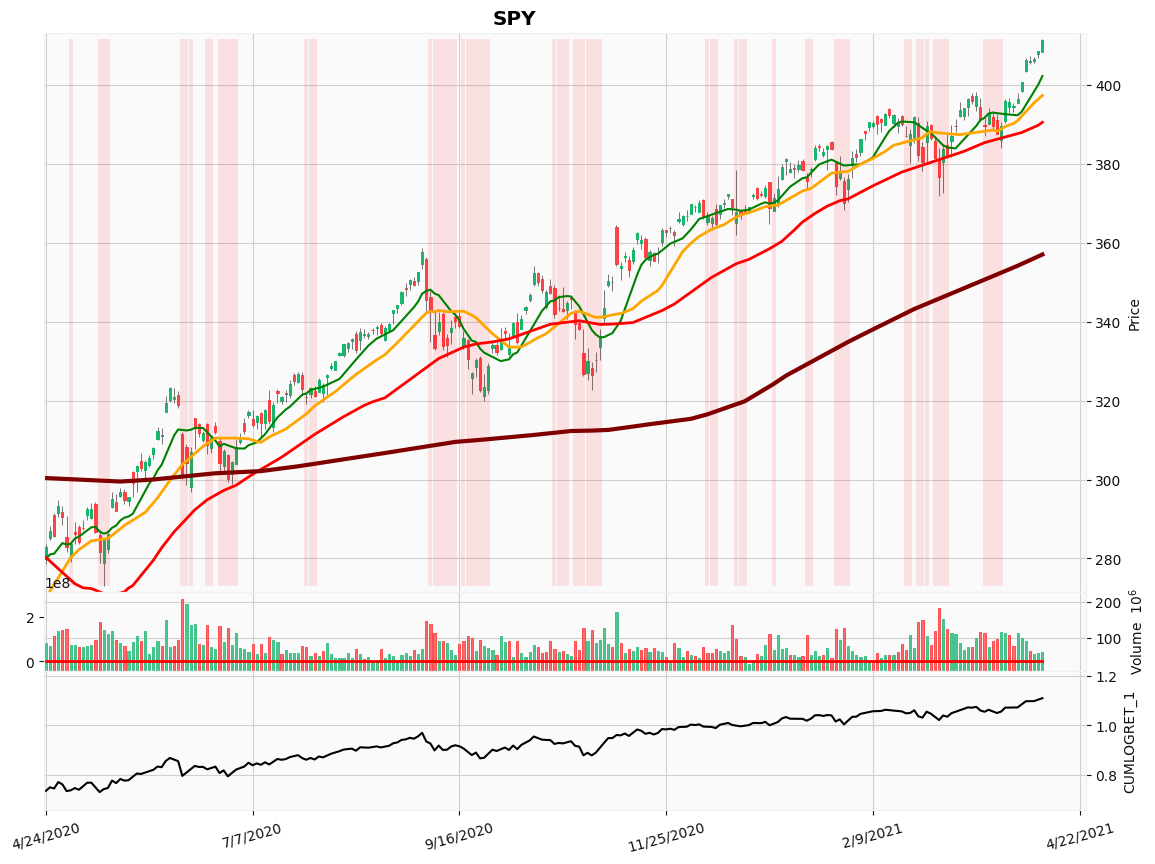


Pandas v: 1.2.2 [pip install pandas] https://github.com/pandas-dev/pandas
Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI
Technical Analysis with Pandas TA v: 0.2.64b0 [pip install pandas_ta] https://github.com/twopirllc/pandas-ta
Charts by Matplotlib Finance v: 0.12.7a5 [pip install mplfinance] https://github.com/matplotlib/mplfinance



In [19]:
Chart(df, style="yahoo", title=ticker, verbose=False,
    last=recent_bars(df), rpad=10,
    volume=True, midpoint=False, ohlc4=False,
    rsi=False, clr=True, macd=False, zscore=False, squeeze=False, lazybear=False,
    archermas=True, archerobv=False,
    show_nontrading=False, # Intraday use if needed
)

### Archer On Balance Volume
Archer On Balance Volume (__aobv__) returns a DataFrame of OBV, OBV min and max, fast and slow MAs of OBV, and the long and short run trends of the two OBV MAs.
* On the chart below, only **OBV**, **OBV min**, _fast_ and _slow_ **OBV MAs**.
* Not on the chart are: **OBV LR** and **OBV SR** trends.

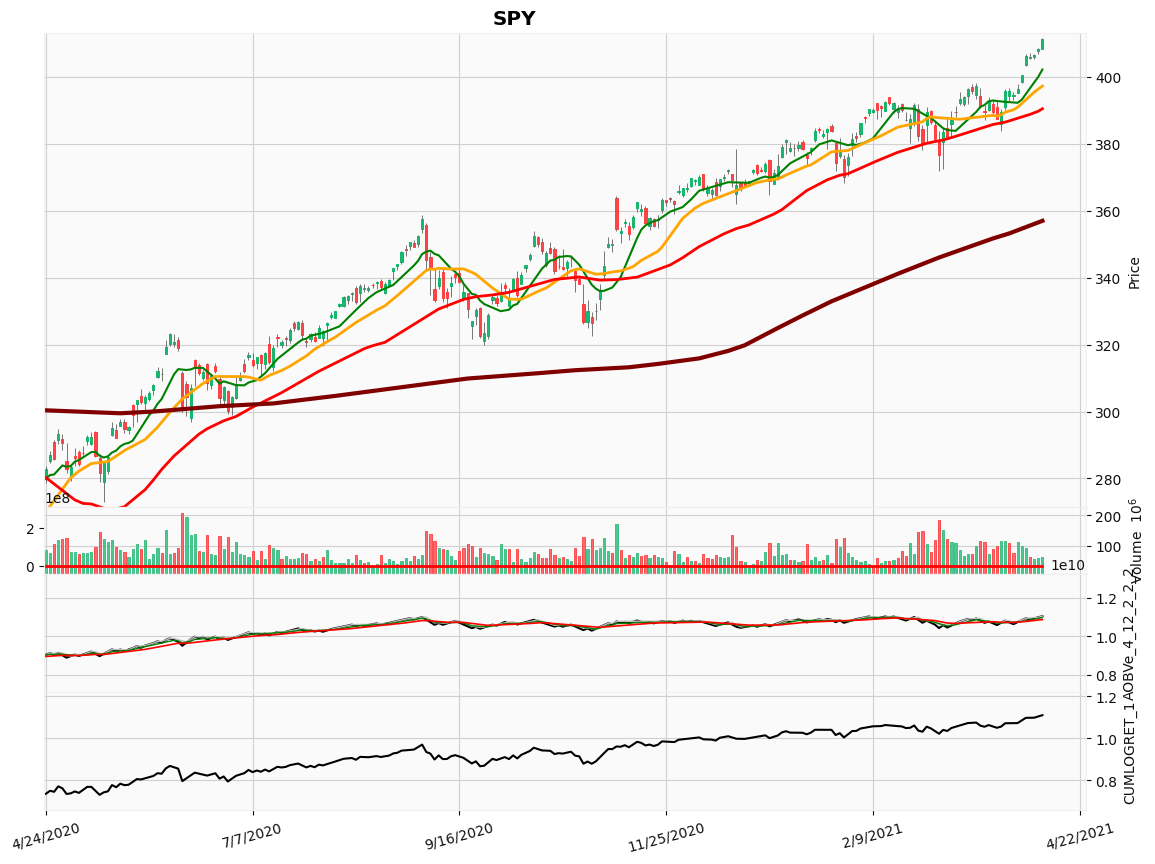


Pandas v: 1.2.2 [pip install pandas] https://github.com/pandas-dev/pandas
Data from AlphaVantage v: 1.0.19 [pip install alphaVantage-api] http://www.alphavantage.co https://github.com/twopirllc/AlphaVantageAPI
Technical Analysis with Pandas TA v: 0.2.64b0 [pip install pandas_ta] https://github.com/twopirllc/pandas-ta
Charts by Matplotlib Finance v: 0.12.7a5 [pip install mplfinance] https://github.com/matplotlib/mplfinance



In [20]:
Chart(df, style="yahoo", title=ticker, verbose=False,
    last=recent_bars(df), rpad=10,
    volume=True, midpoint=False, ohlc4=False,
    rsi=False, clr=True, macd=False, zscore=False, squeeze=False, lazybear=False,
    archermas=False, archerobv=True,
    show_nontrading=False, # Intraday use if needed
)

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.